# (Reduzierter) Data Science Lebenszyklus
1\. Probleme identifizieren\
2\. Daten sammeln und zusammenführen\
3A. Daten bearbeiten\
3B. Daten erkunden\
3C. Daten analysieren\
4\. Resultate visualisieren

In [12]:
# import statements
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as dates
from datetime import datetime
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
from scipy.ndimage import maximum_filter1d
import warnings
warnings.filterwarnings('ignore')

In [13]:
# visualization 
def plot_time_series_data_w_scatter(data, scatters, formatter="%m-%d"):
    measure = data.columns[0]
    axis = data[measure].plot.line(x_compat=True)
    scatters.plot(style="x")

    axis.xaxis.set_major_locator(matplotlib.ticker.LinearLocator(14))
    axis.xaxis.set_major_formatter(dates.DateFormatter(formatter))
    plt.autoscale(enable=True, axis='x', tight=True)
    axis.pcolorfast(axis.get_xlim(), axis.get_ylim(),
          data['week_indicator'].values[np.newaxis], 
          cmap = "Greys_r", alpha = 0.1)

    pass

def plot_time_series_data(data, formatter="%m-%d"):
    measure = data.columns[0]
    
    axis = data[measure].plot.line(x_compat=True)
    axis.xaxis.set_major_locator(matplotlib.ticker.LinearLocator(7))
    axis.xaxis.set_major_formatter(dates.DateFormatter(formatter))
    
    plt.autoscale(enable=True, axis='x', tight=True)
    axis.pcolorfast(axis.get_xlim(), axis.get_ylim(),
          data['week_indicator'].values[np.newaxis], 
          cmap = "Greys_r", alpha = 0.1)
    
    pass

def plot_multiple_time_series_data(data, formatter="%m-%d"):
    measures = data.columns
    axis = data[measures[0]].plot.line(x_compat=True)
    axis.xaxis.set_major_locator(matplotlib.ticker.LinearLocator(7))
    axis.xaxis.set_major_formatter(dates.DateFormatter(formatter))
    
    axis2 = axis.twinx()
    axis2.plot(data.index, data[measures[1]], color="black")
    
    plt.autoscale(enable=True, axis='x', tight=True)
    axis.pcolorfast(axis.get_xlim(), axis.get_ylim(),
          data['week_indicator'].values[np.newaxis], 
          cmap = "Greys_r", alpha = 0.1)
    return axis, axis2
    #pass

In [14]:
# detection algorithms
def calculate_peaks(data, prom, dist):
    measure = data.columns[0]
    data_array = data[measure].ravel()
    peaks, props = find_peaks(data_array, prominence=prom, distance=dist)
    peaks_df = pd.Series(data_array[peaks], index=data.index[peaks])
    print(props["prominences"])
    
    plot_time_series_data_w_scatter(data, peaks_df)

    return peaks_df.index

def calculate_peak(data, prom):
    measure = data.columns[0]
    data_array = data[measure].ravel()

    peaks, props = find_peaks(data_array, prominence=prom)
    peaks_df = pd.Series(data_array[peaks], index=data.index[peaks])
    print(props["prominences"])

    plot_time_series_data_w_scatter(data, peaks_df[-1:], "%H:%M")
    return 

def calculate_lowest_points(data, prom):
    data_array = data[measure].ravel()
    lows, props = find_peaks(data_array * -1, prominence=prom)

    # retrieve indices and take the earliest ones
    # thus takes earliest minimum
    lows_idx = pd.Series(data.index[lows])
    print(props["prominences"])

    lows_df = pd.Series(data_array[lows], index=data.index[lows])

    lows_df = lows_df[lows_idx[lows_idx.groupby(lows_idx.dt.date).idxmin()]]
    plot_time_series_data_w_scatter(data, lows_df)
    print(lows_df.index)

    return lows_df.index
                                    


## Daten sammeln und zusammenführen

In [15]:
# load data from files
file_path = "./data/JR_blueSensor-"
february_df = pd.read_csv(file_path+"CO2_20230228.csv", sep=";")
march_df = pd.read_csv(file_path+"CO2_20230328.csv", sep=";")

# consolidate data
# consolidating with same schema is easy, gets trickier with distinct data schemas
whole_df = pd.concat([february_df, march_df], axis=0)
whole_df.head()

,Date,Time,CO2 (ppm),VOC Index (voc),Humidity (%),Temperature (°C)
0,2023-03-01,00:57,828,128,27.7,23.6
1,2023-03-01,00:47,830,128,27.7,23.6
2,2023-03-01,00:37,832,127,27.7,23.7
3,2023-03-01,00:27,833,128,27.7,23.7
4,2023-03-01,00:18,839,127,27.7,23.7


A brief peak into data:

In [16]:
whole_df.shape

(3111, 6)

In [17]:
whole_df.dtypes

Date                 object
Time                 object
CO2 (ppm)             int64
VOC Index (voc)       int64
Humidity (%)        float64
Temperature (°C)    float64
dtype: object

## Daten bearbeiten

In [18]:
# join date and time to create unique identifier that will be used as index
whole_df["ts"] = pd.to_datetime(whole_df['Date'] + ' ' + whole_df['Time'])
whole_df.sort_values(by=["ts"], inplace=True)
whole_df.set_index("ts", inplace=True)
whole_df.head()

,Date,Time,CO2 (ppm),VOC Index (voc),Humidity (%),Temperature (°C)
ts,,,,,,
2023-02-14 10:26:00,2023-02-14,10:26,0,0,27.3,26.1
2023-02-14 10:26:00,2023-02-14,10:26,0,0,27.3,26.1
2023-02-14 10:26:00,2023-02-14,10:26,0,0,27.3,26.0
2023-02-14 10:27:00,2023-02-14,10:27,982,47,27.2,26.0
2023-02-14 10:29:00,2023-02-14,10:29,982,67,25.0,25.8


In [19]:
# retrieve date ranges
print(f"start date: {whole_df.first_valid_index()}")
print(f"end date: {whole_df.last_valid_index()}")

start date: 2023-02-14 10:26:00
end date: 2023-03-07 08:10:00


In [20]:
# restrict data range to complete days
start_date = datetime.strptime("2023-02-15 00:00:01", "%Y-%m-%d %H:%M:%S")
end_date = datetime.strptime("2023-03-06 23:59:59", "%Y-%m-%d %H:%M:%S")

whole_df = whole_df.loc[start_date:end_date]
whole_df.head()

,Date,Time,CO2 (ppm),VOC Index (voc),Humidity (%),Temperature (°C)
ts,,,,,,
2023-02-15 00:04:00,2023-02-15,00:04,634,119,28.7,23.8
2023-02-15 00:13:00,2023-02-15,00:13,643,120,28.7,23.8
2023-02-15 00:23:00,2023-02-15,00:23,642,119,28.7,23.8
2023-02-15 00:33:00,2023-02-15,00:33,641,120,28.7,23.8
2023-02-15 00:43:00,2023-02-15,00:43,638,119,28.8,23.7


In [21]:
# check if timestamps make sense
# above we saw multiple identical timestamps, check which ones appear multiple times
whole_df.index.value_counts()

2023-02-28 07:54:00    4
2023-02-27 13:55:00    4
2023-02-27 13:56:00    3
2023-02-28 10:59:00    3
2023-02-28 12:33:00    2
                      ..
2023-02-21 17:43:00    1
2023-02-21 17:53:00    1
2023-02-21 18:03:00    1
2023-02-21 18:13:00    1
2023-03-06 23:58:00    1
Name: ts, Length: 2948, dtype: int64

In [22]:
# index should be unique, thus delete 'duplicates'
whole_df = whole_df[~whole_df.index.duplicated(keep='first')]
whole_df.index.value_counts()

2023-02-15 00:04:00    1
2023-02-28 09:21:00    1
2023-02-28 08:01:00    1
2023-02-28 08:12:00    1
2023-02-28 08:22:00    1
                      ..
2023-02-21 17:43:00    1
2023-02-21 17:53:00    1
2023-02-21 18:03:00    1
2023-02-21 18:13:00    1
2023-03-06 23:58:00    1
Name: ts, Length: 2948, dtype: int64

After taking a closer look at the timestamps we can see that the data has a sampling rate of roughly ~10 minutes. Which means that roughly every 10 minutes a data point should be present.

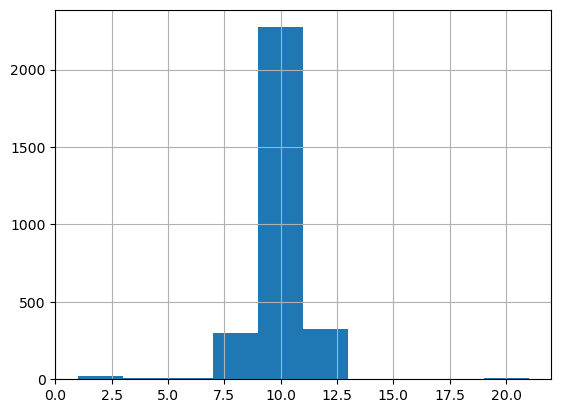

In [23]:
# check whether this assumption holds true
diff = whole_df.index.to_series().diff(1)
sampling_minutes = diff.dt.total_seconds() / 60 # seconds to minutes

sampling_minutes.hist(bins=10)

# remove all rows whose temporal distance is < 8 to the previous timestamp
# may not be the best way of dropping timestamps but is the easiest one
to_drop = sampling_minutes[sampling_minutes < 8]
whole_df = whole_df[~whole_df.index.isin(to_drop.index)]

In [24]:
whole_df["week_indicator"] = (pd.Series(whole_df.index, index=whole_df.index).dt.isocalendar()["week"] % 2).astype("int64")

Other important pre-processing steps include checking for missing values and whether the values are within bounds. Latter only checks if signal makes sense in a numerical way, and not locally.

In [25]:
# check for missing values
whole_df.isnull().sum()

Date                0
Time                0
CO2 (ppm)           0
VOC Index (voc)     0
Humidity (%)        0
Temperature (°C)    0
week_indicator      0
dtype: int64

In [26]:
# check if CO2 data is within bounds
lower_bound_violation = whole_df[whole_df["CO2 (ppm)"] < 350]
print("Lower Bound Violation:")
print(lower_bound_violation.head())

upper_bound_violation = whole_df[whole_df["CO2 (ppm)"] > 2000]
print("\nUpper Bound Violation:")
print(upper_bound_violation.head())


Lower Bound Violation:
Empty DataFrame
Columns: [Date, Time, CO2 (ppm), VOC Index (voc), Humidity (%), Temperature (°C), week_indicator]
Index: []

Upper Bound Violation:
Empty DataFrame
Columns: [Date, Time, CO2 (ppm), VOC Index (voc), Humidity (%), Temperature (°C), week_indicator]
Index: []


In [27]:
# check if temperature data is within bounds
lower_bound_violation = whole_df[whole_df["Temperature (°C)"] < 16]
print("Lower Bound Violation:")
print(lower_bound_violation.head())

upper_bound_violation = whole_df[whole_df["Temperature (°C)"] > 26]
print("\nUpper Bound Violation:")
print(upper_bound_violation.head())

Lower Bound Violation:
Empty DataFrame
Columns: [Date, Time, CO2 (ppm), VOC Index (voc), Humidity (%), Temperature (°C), week_indicator]
Index: []

Upper Bound Violation:
Empty DataFrame
Columns: [Date, Time, CO2 (ppm), VOC Index (voc), Humidity (%), Temperature (°C), week_indicator]
Index: []


## Daten erkunden and analysieren

### CO2 data

In [28]:
co2_df = whole_df[["CO2 (ppm)", "week_indicator"]]
measure = co2_df.columns[0]
co2_df.head()

,CO2 (ppm),week_indicator
ts,,
2023-02-15 00:04:00,634,1
2023-02-15 00:13:00,643,1
2023-02-15 00:23:00,642,1
2023-02-15 00:33:00,641,1
2023-02-15 00:43:00,638,1


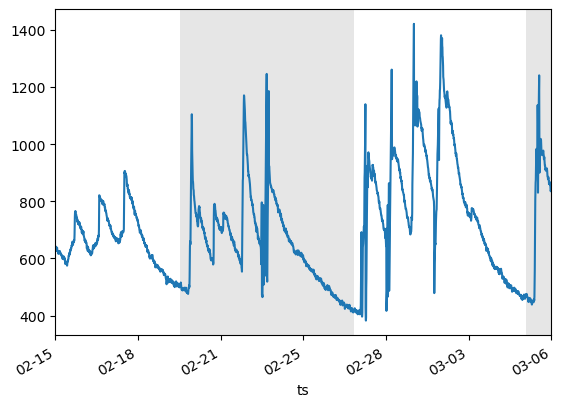

In [29]:
# plot whole data
plot_time_series_data(co2_df)

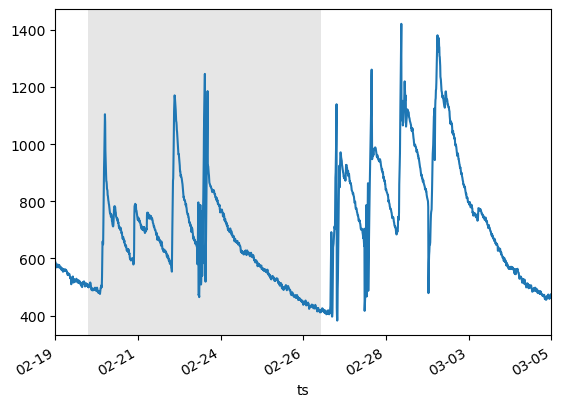

In [30]:
# cut dataframe because we want full week
# keep sunday for detection of lowest points

start_date = datetime.strptime("2023-02-19 00:00:01", "%Y-%m-%d %H:%M:%S")
end_date = datetime.strptime("2023-03-05 23:59:59", "%Y-%m-%d %H:%M:%S")

co2_df = co2_df.loc[start_date:end_date]
plot_time_series_data(co2_df)

[550. 212. 694. 780. 742. 576. 964. 901.]


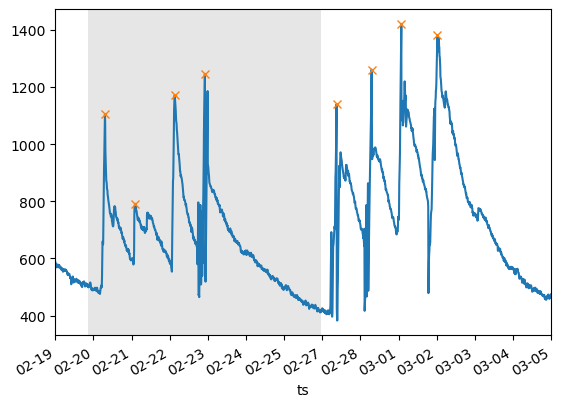

In [32]:
# detects peaks
# 4 peaks indicate that out of 7 days the office was occupied 4 times
# indicates when windows were opened

peak_ts_co2 = calculate_peaks(co2_df, 90, 6*12)

[112.  71. 212.  71. 550. 216. 705. 278. 227.  59. 666. 287. 287. 742.
 862.  75.  55.  61. 554. 320. 376. 576.  68. 154.  60. 901. 180.  57.]
DatetimeIndex(['2023-02-20 08:37:00', '2023-02-21 08:52:00',
               '2023-02-22 12:45:00', '2023-02-23 07:16:00',
               '2023-02-27 04:47:00', '2023-02-28 08:12:00',
               '2023-03-01 07:40:00', '2023-03-02 06:49:00'],
              dtype='datetime64[ns]', name='ts', freq=None)


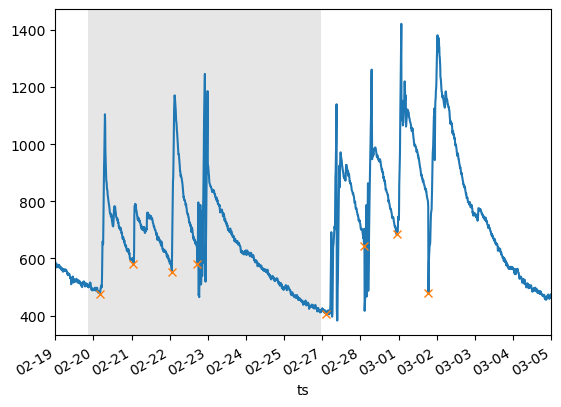

In [37]:
# lowest point detection
# indicates when working hours started

lows_ts_co2 = calculate_lowest_points(co2_df, 50)

Even the end of the working hours can be detected.

[180. 253.  47.]


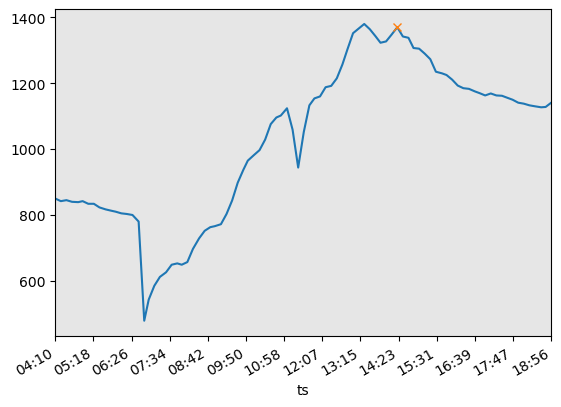

In [39]:
# crop date range to standard working hours
start_date = datetime.strptime("2023-03-02 4:00:01", "%Y-%m-%d %H:%M:%S")
end_date = datetime.strptime("2023-03-02 18:59:59", "%Y-%m-%d %H:%M:%S")

day_df = co2_df.loc[start_date:end_date]
calculate_peak(day_df, 8)

### Temperature data

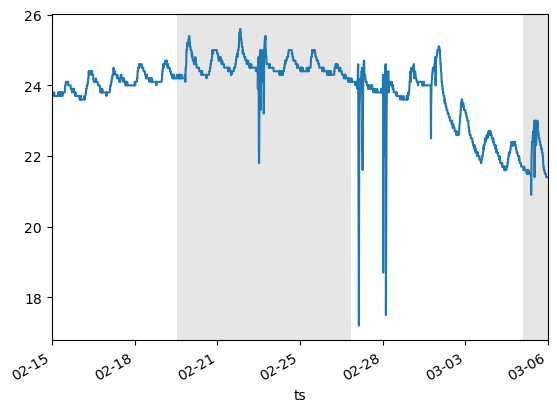

In [44]:
temperature_df = whole_df[["Temperature (°C)", "week_indicator"]]
measure = temperature_df.columns[0]
temperature_df.head()
plot_time_series_data(temperature_df)

Figure shows noisy data for multiple days, maybe even outliers. Smooth signal for better results, makes signal more inaccurate tho.

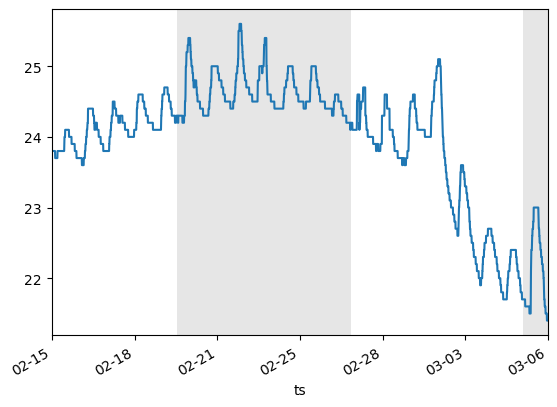

In [45]:
# applies a maximum filter to the temperature data
# filter keeps sharp edges and features
temperature_df["Temperature (°C)"] = maximum_filter1d(temperature_df["Temperature (°C)"], 10)
plot_time_series_data(temperature_df)

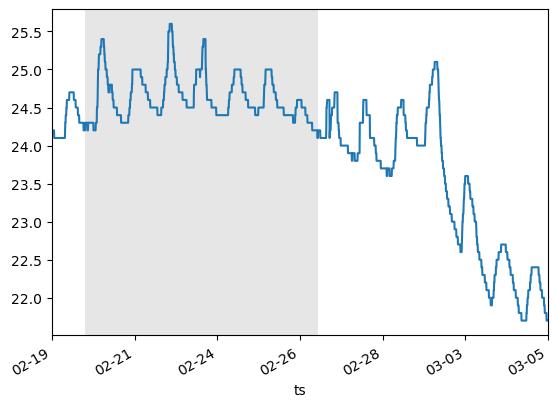

In [46]:
# cut dataframe because first days because we want full weeks
# keep sunday for detection of lowest points
start_date = datetime.strptime("2023-02-19 00:00:01", "%Y-%m-%d %H:%M:%S")
end_date = datetime.strptime("2023-03-05 23:59:59", "%Y-%m-%d %H:%M:%S")

temperature_df = temperature_df.loc[start_date:end_date]
plot_time_series_data(temperature_df)

[1.1 0.6 1.4 0.9 0.6 0.6 0.3 0.6 0.8 0.6 1.5 1.  0.8 0.7]


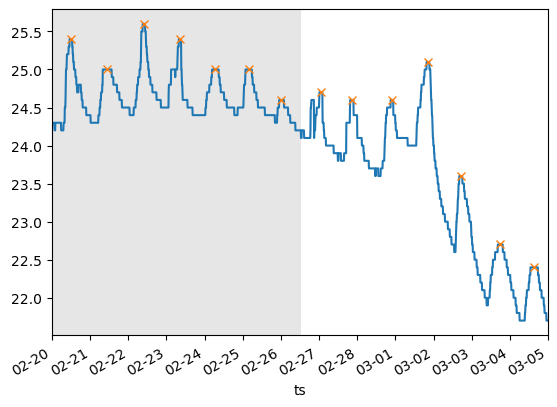

In [47]:
# detects peaks
# remove sunday because temperature data has clearly visible peaks compared to CO2 data
start_date = datetime.strptime("2023-02-20 00:00:01", "%Y-%m-%d %H:%M:%S")
ptemperature_df = temperature_df.loc[start_date:]

peak_ts_temp = calculate_peaks(ptemperature_df, 0.25, 6*12)

[0.5 0.5 0.5 1.1 0.6 0.9 0.6 0.6 0.3 0.6 0.6 0.6 0.8 0.8 1.5 1.5 0.6 1.
 0.8 0.7]
DatetimeIndex(['2023-02-19 23:36:00', '2023-02-20 02:04:00',
               '2023-02-21 04:48:00', '2023-02-22 06:02:00',
               '2023-02-23 04:19:00', '2023-02-24 03:37:00',
               '2023-02-25 04:32:00', '2023-02-26 07:44:00',
               '2023-02-27 00:51:00', '2023-02-28 01:47:00',
               '2023-03-01 03:05:00', '2023-03-02 03:41:00',
               '2023-03-03 08:43:00', '2023-03-04 06:41:00',
               '2023-03-05 06:18:00'],
              dtype='datetime64[ns]', name='ts', freq=None)


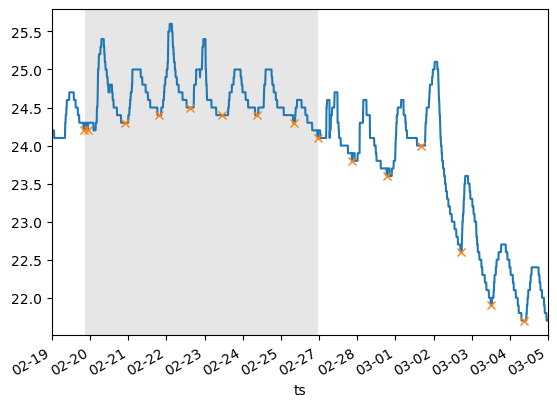

In [118]:
# detect lowest points and discard sunday result
lows_ts_temp = calculate_lowest_points(temperature_df, 0.25)
lows_ts_temp = lows_ts_temp[1:]

In [119]:
# try to assess whether employees were in office or not
highest_temp = temperature_df.loc[peak_ts_temp]["Temperature (°C)"]
lowest_temp = temperature_df.loc[lows_ts_temp]["Temperature (°C)"]
diff = highest_temp.values - lowest_temp.values

temp_increase = pd.DataFrame(diff, index=highest_temp.index)
temp_increase["weekday"] = highest_temp.index.to_series().dt.weekday

print(temp_increase)

                       0  weekday
ts                               
2023-02-20 12:53:00  1.2        0
2023-02-21 13:29:00  0.7        1
2023-02-22 14:14:00  1.2        2
2023-02-23 14:39:00  0.9        3
2023-02-24 14:35:00  0.6        4
2023-02-25 13:09:00  0.6        5
2023-02-26 11:23:00  0.3        6
2023-02-27 14:09:00  0.6        0
2023-02-28 10:58:00  0.8        1
2023-03-01 14:13:00  1.0        2
2023-03-02 14:31:00  1.1        3
2023-03-03 12:49:00  1.0        4
2023-03-04 15:32:00  0.8        5
2023-03-05 14:31:00  0.7        6


Theoretically the physcial attendance of employees could be detected, but interpretation should be handled with care since the room temperature is influenced by many factors. It is easier to take dedicated sensor signals like the CO2 sensor for this task.